In [38]:
import torchdata
import torch
import pandas as pd
import re
import os
import numpy as np
import pickle
from transformers import AutoModel, AutoTokenizer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

IGNORE_SAVED_FILES = True
device = 'cuda'
print(torch.__version__, torch.cuda.is_available())
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
vectorizer = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")


2.0.0+cu117 True


# Functions

In [39]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1



In [40]:
def bad_patterns_to_tags_replaser2(text: str):
    text = re.sub(r'\d+\:\d+\:\d+', ' [UNK] ', text)
    text = re.sub(r'\d+\:\d+', ' [UNK] ', text)
    text = re.sub(r'\+{,1}\d{1,3}\({,1}[\-\s]{,1}\d{3}\){,1}[\-\s]{,1}\d{3}[\-\s]{,1}\d{2}[\-\s]{,1}\d{2}', ' [UNK] ', text)
    text = re.sub('\d+/\d+/\d+', ' [UNK] ', text)
    text = re.sub('\d+-\d+-\d+', ' [UNK] ', text)
    text = re.sub('\d+th', ' [UNK] ', text)
    text = re.sub('\d+rd', ' [UNK] ', text)
    text = re.sub('\d+st', ' [UNK] ', text)
    text = re.sub('[\+\-]?\d+.\d+', ' [UNK] ', text)
    text = re.sub('[\+\-]?\d+,\d+', ' [UNK] ', text)
    text = re.sub('\d+', ' [UNK] ', text)
    # text = re.sub(r'\w+\.', '<SHORT>', text[0:-1]) + '.'
    text = re.sub(',', ' , ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub(':', ' : ', text)
    text = re.sub('\?', ' \? ', text)
    text = re.sub('"', ' " ', text)
    text = re.sub("'", " ' ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\.', ' . ', text)
    text = re.sub('\(', ' ( ', text)
    text = re.sub('\)', ' ) ', text)
    text = re.sub('\.  \.  \.', ' ... ', text)
    text = re.sub('\s+', ' ', text)
    return text[0:-1]


In [41]:
tokenizer.decode

<bound method PreTrainedTokenizerBase.decode of BertTokenizerFast(name_or_path='ai-forever/sbert_large_nlu_ru', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}>

# Prepeare data

In [42]:
if (not IGNORE_SAVED_FILES) and os.path.exists('./only_text.csv'):
    with open('./anek.txt', 'r', encoding='utf-8') as f:
        data = f.read()
    data_r =  data.replace('<|startoftext|>', '').replace('\\', '').split('\n\n')
    data_c =pd.Series(list(map(bad_patterns_to_tags_replaser2, data_r)))
    data_c.to_csv('./only_text.csv', index=False)
else:
    data_c = pd.read_csv('./only_text.csv')



# Choose len

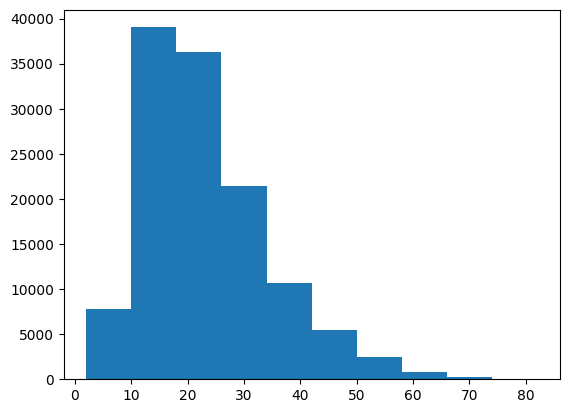

In [43]:
lengthes = data_c['0'].dropna().apply(lambda a: len(a.split()))
plt.hist(lengthes)
plt.show()


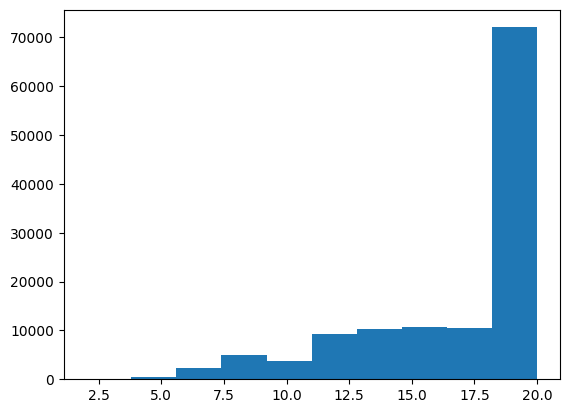

In [44]:
lengthes = data_c['0'].dropna().apply(lambda a: len(a.split()[:20]))
plt.hist(lengthes)
plt.show()


# Norming data

In [45]:
if (not IGNORE_SAVED_FILES) and os.path.exists('./only_text.csv'):
    data_n = data_c['0'].deopna().loc[lengthes >= 15].apply(lambda a: ' '.join(a.split()[0:20])) 
    data_n = data_n.apply(lambda a: pd.Series([' '.join(a.split()[:10]), ' '.join(a.split()[10:])]))
    data_n.to_csv('./normed.csv', index=False)

# Torch data

In [46]:
def s(**args):
    print(args)

In [47]:
def tokenize(sentence):
    return tokenizer([sentence], padding=True, truncation=True, pad_to_multiple_of=10, max_length=10, return_tensors='pt')


def getThreeEnt(text):
    # text
    with torch.no_grad():
        d_t = tokenize(text)
        d_v = vectorizer(**d_t)[0]
    return d_t['input_ids'], d_v, text


def getThreeEntOnPair(pair):
    return getThreeEnt(pair[0]), getThreeEnt(pair[1])


In [48]:
vectorizer(**{'input_ids': torch.tensor([[50],]), 'token_type_ids': torch.tensor([[0],]), 'attention_mask': torch.tensor([[1],])})[0]

tensor([[[-1.2717, -0.2479, -0.9340,  ..., -0.0978,  0.0110,  0.4974]]],
       grad_fn=<NativeLayerNormBackward0>)

In [49]:
output_res = torchdata.datapipes.iter.IterableWrapper(['./normed.csv'])
output_res_pipe = torchdata.datapipes.iter.FileOpener(output_res, mode='r', encoding='utf-8', length=data_c.shape[0])
res_pipe = output_res_pipe.parse_csv(skip_lines=1, delimiter=',')
res_pipe = torchdata.datapipes.map.SequenceWrapper(list(res_pipe))
print_simple_data_pipe(res_pipe, n=3)


<class 'torch.utils.data.datapipes.map.utils.SequenceWrapperMapDataPipe'>
['Только заметил , что слово " п@рно " набирается самими', 'центральными клавишами . Как все продумано , блин']
['Друзья мои , чтобы соответствовать вам , я готов сделать', 'над собой усилие и стать лучше . Но тогда и']
['- Люся , ты все еще хранишь мой подарок \\?', '- Да . - Я думал , ты выкинула все']
['- А вот скажи честно , ты во сне храпишь', '\\? - Понятие не имею , вроде , нет .']


In [50]:
ready = res_pipe.map(getThreeEntOnPair)
print_simple_data_pipe(ready, n=3, f=lambda a: (a[0][0].shape, a[0][1].shape, a[0][2]))

<class 'torch.utils.data.datapipes.map.callable.MapperMapDataPipe'>
(torch.Size([1, 10]), torch.Size([1, 10, 1024]), 'Только заметил , что слово " п@рно " набирается самими')
(torch.Size([1, 10]), torch.Size([1, 10, 1024]), 'Друзья мои , чтобы соответствовать вам , я готов сделать')
(torch.Size([1, 10]), torch.Size([1, 10, 1024]), '- Люся , ты все еще хранишь мой подарок \\?')
(torch.Size([1, 10]), torch.Size([1, 10, 1024]), '- А вот скажи честно , ты во сне храпишь')


In [51]:
res = torchdata.datapipes.map.Shuffler(ready).batch(batch_size=4)
print_simple_data_pipe(res, n=3, f=lambda a: f'batch_size\t:\t{len(a)}\n' + 
                       f'el_size\t:\t{len(a[0])}\n' + 
                       f'el_size\t:\t{a[0][0][0].shape}\n' + 
                       f'el_size\t:\t{a[0][0][1].shape}\n' + 
                       f'el_size\t:\t{a[0][0][2]}\n' 
                    )

<class 'torch.utils.data.datapipes.iter.grouping.BatcherIterDataPipe'>
batch_size	:	4
el_size	:	2
el_size	:	torch.Size([1, 10])
el_size	:	torch.Size([1, 10, 1024])
el_size	:	День . Жена будит мужа : - Нельзя все время

batch_size	:	4
el_size	:	2
el_size	:	torch.Size([1, 10])
el_size	:	torch.Size([1, 10, 1024])
el_size	:	Чувак с очень плохим зрением хочет взять ипотеку , но

batch_size	:	4
el_size	:	2
el_size	:	torch.Size([1, 10])
el_size	:	torch.Size([1, 10, 1024])
el_size	:	Прыгнули два парашютиста с самолета . Летят парашюты не открывают

batch_size	:	4
el_size	:	2
el_size	:	torch.Size([1, 10])
el_size	:	torch.Size([1, 10, 1024])
el_size	:	Он обещал прокатить ее на своей яхте . Она была



In [52]:
train_dataloader = res

# Create model

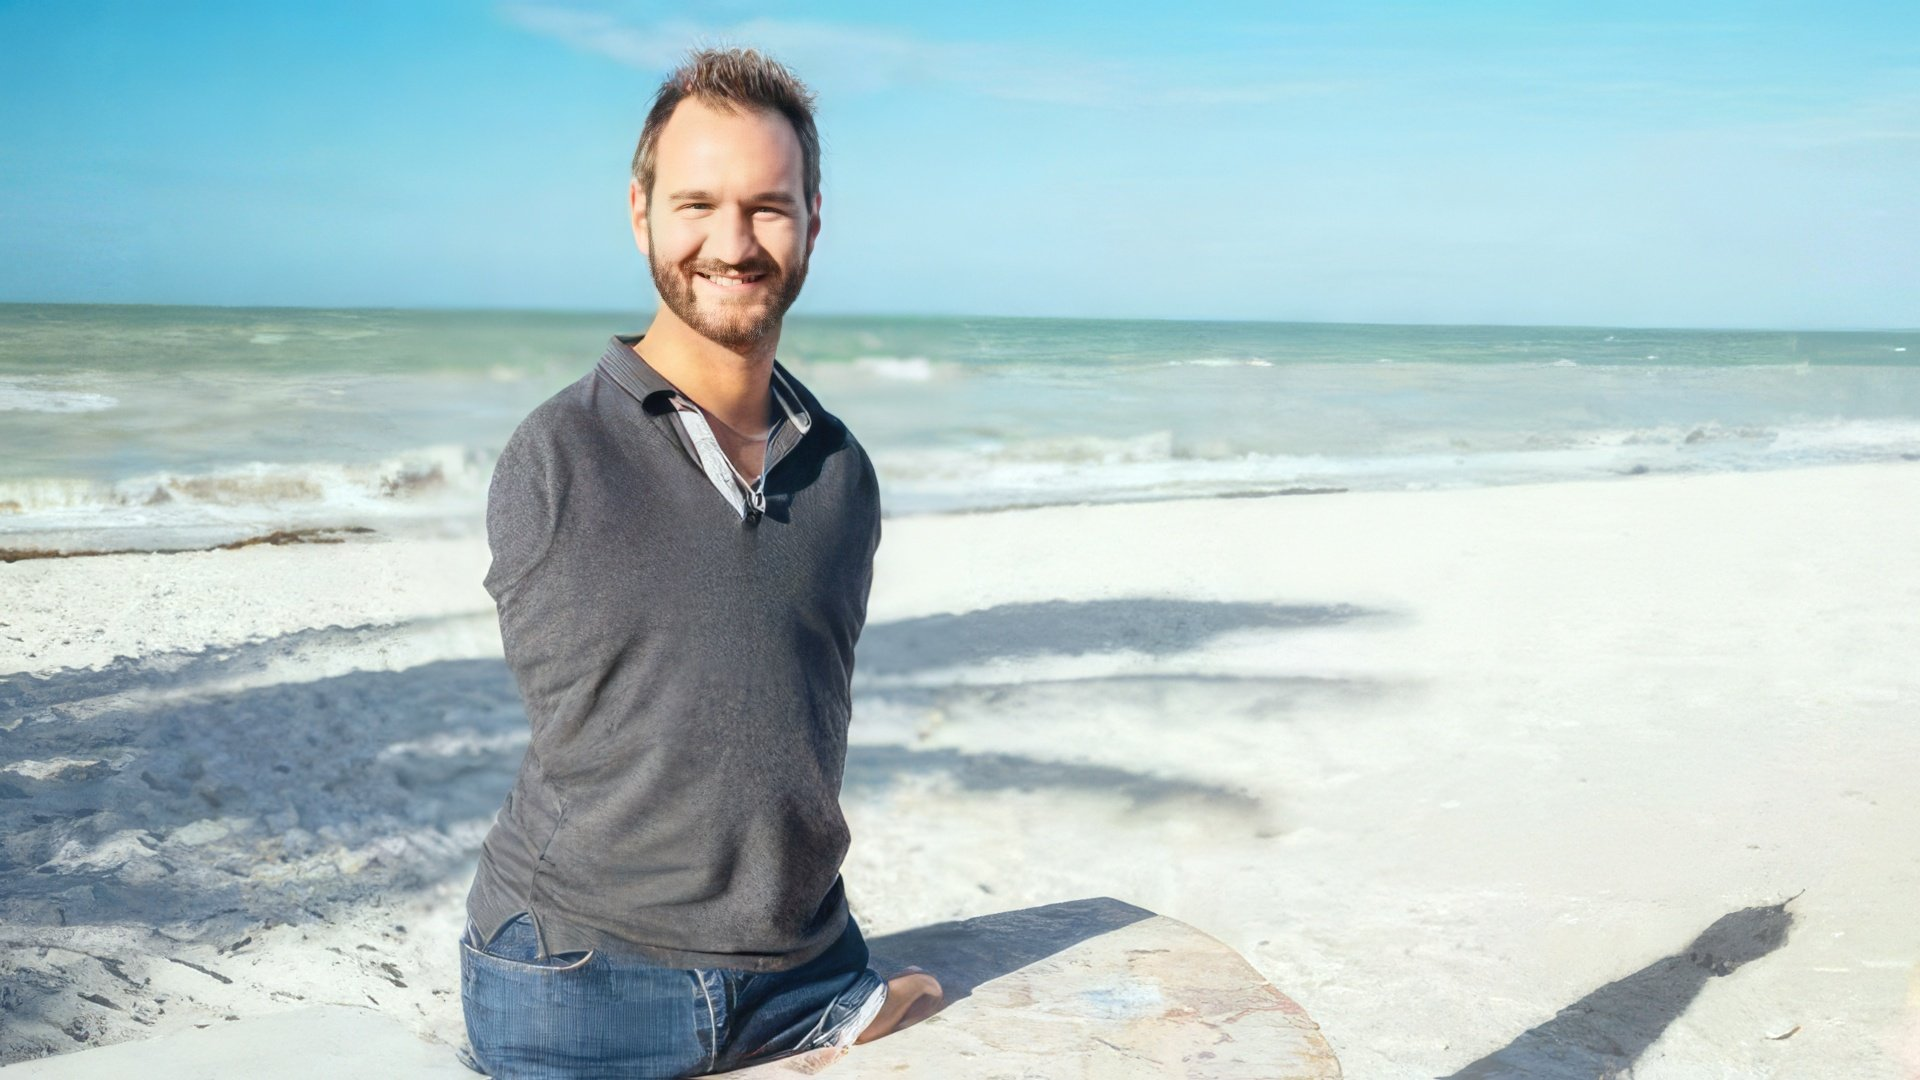

In [53]:
class TransformerAttention(torch.nn.Module):
    def __init__(self, emb_size, n_heads):
        super(TransformerAttention, self).__init__()
        self.n_heads = n_heads
        self.wQ = torch.rand([n_heads, emb_size, emb_size]).to(device)
        self.wK = torch.rand([n_heads, emb_size, emb_size]).to(device)
        self.wV = torch.rand([n_heads, emb_size, emb_size]).to(device)
        self.wO = torch.rand([n_heads * emb_size, emb_size]).to(device)

    def forward(self, en_out):
        eo = en_out.clone()
        for i in range(eo.shape[0]):
            m = eo[i].unsqueeze(0)
            eo[i] = self.iteration(m, m, m)
        return eo

    def iteration(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor):
        d = Q.shape[2]
        s = Q.shape[1]
        qp = Q.repeat(self.n_heads, 1, 1).bmm(self.wQ)
        kp = K.repeat(self.n_heads, 1, 1).bmm(self.wK)
        vp = V.repeat(self.n_heads, 1, 1).bmm(self.wV)
        res = torch.softmax(qp.bmm(kp.transpose(1, 2))/d**0.5, 1)
        res2 = (res.bmm(vp))
        
        return res2.view(s, d * self.n_heads).mm(self.wO)

att = TransformerAttention(1024, 4).to(device)

In [54]:
class Decoder(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
    super(Decoder, self).__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    self.tag = True
    self.embedding = torch.nn.Embedding(self.input_size, self.embedding_size)
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)
    self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

  def forward(self, x, hidden_state):
    # hidden_state 16 10 1024
    embedding = x.contiguous() #.unsqueeze(0)  1 16 1024
    # hidden_state.shape = [1, 11, 128]  ||  [1, batch_size, input_emb_size]
    # x.shape = [1, 11]
    # embedding = self.embedding(x)
    # embedding.shape = [1, 11, 256]  ||  [1, batch_size, input_decoder_emb_size]
    # embedding_size <=> input_decoder_emb_size
    outputs, hidden_state = self.GRU(embedding, hidden_state.transpose(0, 1).contiguous())
    # hidden_state.shape = [1, 11, 128]
    # outputs.shape = [, ], 
    predictions = self.fc(outputs)
    # predictions.shape = [1, 11, 129]  ||  [batch_size, output_emb_size]
    predictions = predictions.squeeze(0)
    return predictions, hidden_state

input_size_decoder = 120138
decoder_embedding_size = 1024
hidden_size = 1024
num_layers = 20
output_size = 120138

decoder_lstm = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, num_layers, output_size).to(device)
print(decoder_lstm)


Decoder(
  (embedding): Embedding(120138, 1024)
  (GRU): GRU(1024, 1024, num_layers=20)
  (fc): Linear(in_features=1024, out_features=120138, bias=True)
)


In [55]:
def embTokenVec(token):
    with torch.no_grad():
        return vectorizer(**{'input_ids': token.view(1, -1).to('cpu'), 'token_type_ids': torch.zeros(1, token.shape[0]).long(), 'attention_mask': torch.ones(1, token.shape[0]).long()})[0].to(device)

In [56]:
class Seq2Seq(torch.nn.Module):
  def __init__(self, Decoder, att):
    super(Seq2Seq, self).__init__()
    self.Decoder = Decoder
    self.att = att

  def forward(self, source, source_v, target, target_v, tfr=0.5):
    source = source.squeeze(1)
    source = source.transpose(0, 1)
    target = target.transpose(0, 1)
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = self.Decoder.input_size
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device) # hidden_state_encoder.shape = [5, 11, 129]  ||  [out_len_of_seq, batch_size, output_emb_size]
    hidden_state_encoder = torch.cat([source_v.contiguous(), torch.zeros(*target_v.shape).to(device)], 1)
    x = target[0,:]  # x.shape = [11]  ||  [batch_size]
    for i in range(1, target_len):
      output, _ = self.Decoder(embTokenVec(x).contiguous(), hidden_state_encoder)  # output.shape = [11, 129]  ||  [batch_size, output_emb_size]
      best_guess = output.argmax(1)
      hidden_state_encoder[:, i + source.shape[0] - 1, :] += embTokenVec(best_guess).contiguous()[0]
      hidden_state_encoder = self.att(hidden_state_encoder) / 100000
      outputs[i] = output
      x = target[i] if np.random.random() < tfr else best_guess
    return outputs.transpose(0, 1)
  
transformer = Seq2Seq(decoder_lstm, att).to(device)



Expected hidden size (1, 3, 1024), got [10, 3, 1024]

# Test

In [57]:
def batch_normalizer(batch):
    s1 = []
    s2 = []
    s3 = []
    t1 = []
    t2 = []
    t3 = []
    for i in batch:
        s1.append(i[0][0])
        s2.append(i[0][1])
        s3.append(i[0][2])
        t1.append(i[1][0])
        t2.append(i[1][1])
        t3.append(i[1][2])
    return torch.concat(s1).to(device), torch.concat(s2).to(device), s3, torch.concat(t1).to(device), torch.concat(t2).to(device), t3

In [58]:
for i in res:
    test_batch = batch_normalizer(i)
    break

In [59]:
r = transformer(test_batch[0], test_batch[1], test_batch[3], test_batch[4])

In [60]:
r.argmax(2)

tensor([[     0,  76892,  76892,  65527,  29865,  88560,  46814,  97671,  97671,
          97671],
        [     0,  76892,  76892,  94124,  29865,  39867, 118736,  97671,  30875,
          97671],
        [     0,  76892,  76892,  21213,  29865,  23892,  41413,   6934,  86385,
          97671],
        [     0,  76892,  76892,  65527,  29865,  23892, 118736, 109823,  86385,
          97671]], device='cuda:0')

In [61]:
tokenizer.decode(r.argmax(2)[0])

'[PAD] задеклари задеклари ТНК применяются служанчивы Ассоши Ассоши Ассоши'

In [62]:
test_batch[1].shape

torch.Size([4, 10, 1024])

# Test

In [63]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.00005)


In [64]:
vocab_size = 120138

In [65]:
# torch.nn.functional.one_hot(b[3], vocab_size).shape, outputs.double().shape

In [66]:
epochs = 5
model_num = 0
for epoch in range(epochs):
    t = 0
    for batch in train_dataloader:
        b = batch_normalizer(batch)
        outputs = transformer(b[0], b[1], b[3], b[4])
        loss_value = loss(
            outputs.double().transpose(1, 2),
            torch.nn.functional.one_hot(b[3], vocab_size).double().transpose(1, 2)
        )
        optimizer.step()
        optimizer.zero_grad()
        
        with torch.no_grad():
            if t > 100: 
                break 
            if t % 50 == 0:
                print('\n' + '='*20 + f'Predict of: ./transformer_number{model_num}.pt' + '='*20)
                print()
                print(loss_value)
                print()
                for i, j, k in zip(outputs.argmax(2), b[3], b[0]):
                    print(tokenizer.decode(k))
                    print(tokenizer.decode(j))
                    print(tokenizer.decode(i))
                    print()
                print('-'*30)
                torch.save(transformer, f'./transformer_number{model_num}.pt')
                model_num += 1
            t += 1
        
        


====================Predict of: ./transformer_number0.pt====================

tensor(12.4127, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)

[CLS] маиор мельниченко опубликовал новые аудиозаписи [SEP]
[CLS] президента украины. на этот раз это [SEP]
[PAD] задеклари задеклари задеклари долгового Америка простоте начинающие представляя вошло

[CLS] переехали в двухкомнатную квартиру из однушки [SEP]
[CLS] обладательница бардака в целых двух комнатах [SEP] [PAD]
[PAD] задеклари задеклари уровню применяются хранение проступки Этьен Минфином Ассоши

[CLS] - а я кушаю орехи, и [SEP]
[CLS] зрение на [UNK] %. - а я [SEP]
[PAD] задеклари задеклари уровню применяются приносили начинающие Ассоши Ассоши Ассоши

[CLS] как человек, я никому не интересен - [SEP]
[CLS], потому что не пью, для женщин [SEP]
[PAD] задеклари задеклари одура долгового частного 1991 штабов вошло Этьен

------------------------------

====================Predict of: ./transformer_number1.pt===================